In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import FactorAnalysis, PCA
import tensortools as tt
from tensortools.operations import unfold as tt_unfold, khatri_rao
import tensorly as tl
from tensorly import unfold as tl_unfold
from tensorly.decomposition import parafac,non_negative_parafac

from sklearn.preprocessing import scale

from sklearn.preprocessing import normalize

import copy

import os
import pickle

from sklearn.feature_selection import mutual_info_classif

from tqdm import tqdm_notebook as tqdm

import sklearn

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold

In [2]:
#colormap setting

import matplotlib as mpl
cmaplist=['mediumblue','red','deepskyblue','hotpink']
# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, 4)

cmaplist1=['coral','violet']
# create the new map
cmap1 = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, 2)

cmaplist2=['deepskyblue','lawngreen']
# create the new map
cmap2 = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, 2)

cmaplist3=['black','green']
# create the new map
cmap3 = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, 2)

# import dataset

In [3]:
filenames=[
 'V1_L23_9_20170815',
 'V1_L5_9_20170910',
 'medial_PPC_L23_9_20170810',
 'medial_PPC_L23_9_20170819',
 'medial_PPC_L5_9_20170912',
 'medial_PPC_L5_9_20170921',
 'RSC_L23_9_20170808',
 'RSC_L23_9_20170817',
 'RSC_L5_9_20170911',
 'RSC_L5_9_20170922',
 'visA_L23_9_20170812',
 'visA_L5_9_20170908',]

In [4]:
for filename in ['V1_L23_9_20170815']:
    #1.import original data
    os.chdir(f'/Users/siyanzhou/desktop/rotation/Chris/data')
    with open(filename, 'rb') as handle:
        data = pickle.load(handle)
        
    #2.import aligned data
    os.chdir(f'/Users/siyanzhou/desktop/rotation/Chris/data/aligned_data_50')
    aligned_filename=filename+'_aligned.npy'
    aligned_data=np.load(aligned_filename)
    n_trial,n_neuron,n_bin=aligned_data.shape
    aligned_data[np.isnan(aligned_data)]=0 #there might be incomplete trails
    
    #3.get trial type from original data
    frame_trial=copy.deepcopy(data['beh_dict']['frameTrialMem'][0,:])
    trials=np.unique(frame_trial,return_counts=True)
    idx_trials=trials[0][trials[1]>50] #the idx of trails with frames>50
    cue=np.zeros(idx_trials.shape[0])
    cho=np.zeros(idx_trials.shape[0])
    rew=np.zeros(idx_trials.shape[0])
    mpa=np.zeros(idx_trials.shape[0])
    rule=np.zeros(idx_trials.shape[0])
    bias_signed=np.zeros(idx_trials.shape[0])
    rule_following=np.zeros(idx_trials.shape[0])
    bias_following=np.zeros(idx_trials.shape[0])
    trialVis=np.zeros(idx_trials.shape[0])

    for (j,idx_trial) in enumerate(idx_trials):
        cue[j]=data['beh_dict']['trialCueB'][0,int(idx_trial)-1]
        cho[j]=data['beh_dict']['trialChoL'][0,int(idx_trial)-1]
        rew[j]=data['beh_dict']['trialRew'][0,int(idx_trial)-1]
        mpa[j]=data['strat_dict']['mpa'][int(idx_trial)-1]
        rule[j]=data['strat_dict']['rule'][0,int(idx_trial)-1]
        bias_signed[j]=data['strat_dict']['bias_signed'][int(idx_trial)-1]
        rule_following[j]=data['strat_dict']['rule_following'][int(idx_trial)-1]
        bias_following[j]=data['strat_dict']['bias_following'][int(idx_trial)-1]
        trialVis[j]=data['beh_dict']['trialVis'][0,int(idx_trial)-1]
    
    #the four trial types
    trialtype=np.zeros(idx_trials.shape[0])
    trialtype[np.logical_and(cue==1,cho==1)]=1
    trialtype[np.logical_and(cue==1,cho==0)]=2
    trialtype[np.logical_and(cue==0,cho==1)]=3
    trialtype[np.logical_and(cue==0,cho==0)]=4
    
    #4.statistic on trial length
    #end of trial
    end_trial=np.zeros(n_trial,'int16')
    #end in maze
    end_maze=np.zeros(n_trial,'int16')
    for (i,idx_trial) in enumerate(idx_trials):
        offset=data['beh_dict']['choFrameOffsets'][0,frame_trial==idx_trial]
        end_maze[i]=int(np.argmin(np.abs(offset)))
        end_trial[i]=np.sum(frame_trial==idx_trial)
        
    #5.combine no-binned activity
    activity = copy.deepcopy(data['neural_dict']['deconv'])
    activity_nobin=[]
    for idx_trial in idx_trials:
        activity_i=activity[frame_trial==idx_trial]
        activity_nobin.append(activity_i)

In [5]:
#input data X: (nb_sequence, nb_timestep, nb_feature)
X=np.transpose(aligned_data,(0,2,1))

In [6]:
X.shape

(378, 20, 630)

# helper functions

In [7]:
import keras
from IPython.display import clear_output
import pydot
import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical, np_utils,plot_model
from keras import backend as K
from keras.models import Model, Sequential
from keras.layers import Embedding, Dense, TimeDistributed, LSTM, Activation, Flatten
from keras.layers import Dropout, Lambda, RepeatVector,Masking,Input,Bidirectional
from keras.optimizers import SGD, RMSprop, Adam
from keras import objectives

Using TensorFlow backend.


In [8]:
#helper function: plot learning curve during training
class PlotLearning(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.yscale('log')
        plt.plot(self.x, self.losses, label="loss")
        plt.ylabel('loss')
        plt.xlabel('epochs')
        plt.legend()
        plt.show();
        
plot = PlotLearning()

In [9]:
#data generation function
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras, currently only support batch_size=1'
    def __init__(self, data, label, batch_size=1, shuffle=True):
        'Initialization'
        self.batch_size = batch_size
        self.data=data
        self.label = label
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        sample_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Generate data
        X, y = self.__data_generation(sample_indexes)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.data))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, sample_indexes):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        sample_indexes=int(sample_indexes)
        
        X= self.data[sample_indexes]
        y= self.label[sample_indexes]
        X=X.reshape(1,X.shape[0],X.shape[1])
        y=y.reshape(1,y.shape[0],y.shape[1])

        return X, y

# models

In [10]:
def AE(input_dim, timesteps, batch_size,latent_dim,latent_fac):
    inputs = Input(shape=(timesteps, input_dim))
    bi_latent_dim=int(latent_dim/2)
    encoded = Bidirectional(LSTM(bi_latent_dim,dropout = 0.1, recurrent_dropout = 0.1))(inputs)

    decoded1 = RepeatVector(timesteps)(encoded)
    decoded2 = LSTM(latent_dim, return_sequences=True)(decoded1)
    decoded3 = Dense(latent_fac, activation='relu')(decoded2)
    decoded4 = Dense(input_dim, activation='relu')(decoded3)
    
    ae = Model(inputs, decoded4)
    ae_encoder = Model(inputs, encoded)
    ae_encoder2 = Model(inputs,decoded3)

    ae.compile(optimizer='adam', loss='mse')
    return ae,ae_encoder,ae_encoder2

In [121]:
ae,_,_=AE(input_dim=n_neuron, timesteps=n_bin, batch_size=5, latent_dim=20,
                          latent_fac=10)

In [122]:
ae.summary()

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 20, 630)           0         
_________________________________________________________________
bidirectional_7 (Bidirection (None, 20)                51280     
_________________________________________________________________
repeat_vector_19 (RepeatVect (None, 20, 20)            0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 20, 20)            3280      
_________________________________________________________________
dense_25 (Dense)             (None, 20, 10)            210       
_________________________________________________________________
dense_26 (Dense)             (None, 20, 630)           6930      
Total params: 61,700
Trainable params: 61,700
Non-trainable params: 0
______________________________________________________

In [11]:
def create_binned_lstm_vae(input_dim, 
    timesteps, 
    batch_size, 
    intermediate_dim, 
    latent_dim,
    latent_fac,
    epsilon_std=1.):

    """
    Creates an LSTM Variational Autoencoder (VAE). Returns VAE, Encoder, Generator. 
    # Arguments
        input_dim: int.
        timesteps: int, input timestep dimension.
        batch_size: int.
        intermediate_dim: int, output shape of LSTM. 
        latent_dim: int, latent z-layer shape. 
        epsilon_std: float, z-layer sigma.
    # References
        - [Building Autoencoders in Keras](https://blog.keras.io/building-autoencoders-in-keras.html)
        - [Generating sentences from a continuous space](https://arxiv.org/abs/1511.06349)
    """
    #define input shape
    x = Input(shape=(timesteps, input_dim))
    
    # LSTM encoding
    bi_intermediate_dim=int(intermediate_dim/2)
    h = Bidirectional(LSTM(bi_intermediate_dim, dropout = 0.1, recurrent_dropout = 0.1))(x)

    # VAE Z layer
    z_mean = Dense(latent_dim)(h)
    z_log_sigma = Dense(latent_dim)(h)
    
    def sampling(args):
        z_mean, z_log_sigma = args
        epsilon = K.random_normal(shape=(batch_size, latent_dim),
                                  mean=0., stddev=epsilon_std)
        return z_mean + z_log_sigma * epsilon

    # note that "output_shape" isn't necessary with the TensorFlow backend
    # so you could write `Lambda(sampling)([z_mean, z_log_sigma])`
    z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])
    
    #repeat layer
    h_decoded=RepeatVector(timesteps)(z)
    
    # decoded LSTM layer
    decoder_h1 = LSTM(intermediate_dim, return_sequences=True, dropout = 0.1, recurrent_dropout = 0.1)
    
    # decoded Dense layer
    decoder_h2 = TimeDistributed(Dense(latent_fac, activation = 'relu'))
    decoder_out = Dense(input_dim, activation = 'exponential')
    
    #join decoded layers
    h_decoded1 = decoder_h1(h_decoded)
    h_decoded2 = decoder_h2(h_decoded1)
    x_decoded_out = decoder_out(h_decoded2)
    
    # end-to-end autoencoder
    vae = Model(x, x_decoded_out)
    # encoder, from inputs to latent space
    vae_encoder = Model(x, z_mean)
    # encoder2, from inputs to latent trajectory
    vae_encoder2=Model(x,h_decoded2)
  
    #loss function = poisson objective function + KL_loss
    def vae_loss(x, x_decoded_out):
        xent_loss = objectives.poisson(x, x_decoded_out)
        kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma))
        loss = xent_loss + kl_loss
        return loss

    optimizer=Adam(lr=0.01)
    vae.compile(optimizer=optimizer, loss=vae_loss, metrics=['poisson'])
    
    return vae,vae_encoder,vae_encoder2

In [116]:
vae_binned,_,_=create_binned_lstm_vae(input_dim=n_neuron, timesteps=20, batch_size=1,
                                                   intermediate_dim=20, latent_dim=20,latent_fac=10,epsilon_std=1.)

In [117]:
vae_binned.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 20, 630)      0                                            
__________________________________________________________________________________________________
bidirectional_5 (Bidirectional) (None, 20)           51280       input_9[0][0]                    
__________________________________________________________________________________________________
dense_19 (Dense)                (None, 20)           420         bidirectional_5[0][0]            
__________________________________________________________________________________________________
dense_20 (Dense)                (None, 20)           420         bidirectional_5[0][0]            
___________________________________________________________________________________________

### 1. VAE with no-binning

In [12]:
def create_lstm_vae(input_dim, 
    timesteps, 
    batch_size, 
    intermediate_dim, 
    latent_dim,
    latent_fac,
    epsilon_std=1.):

    """
    Creates an LSTM Variational Autoencoder (VAE). Returns VAE, Encoder, Generator. 
    # Arguments
        input_dim: int.
        timesteps: int, input timestep dimension.
        batch_size: int.
        intermediate_dim: int, output shape of LSTM. 
        latent_dim: int, latent z-layer shape. 
        epsilon_std: float, z-layer sigma.
    # References
        - [Building Autoencoders in Keras](https://blog.keras.io/building-autoencoders-in-keras.html)
        - [Generating sentences from a continuous space](https://arxiv.org/abs/1511.06349)
    """
    #define input shape
    x = Input(shape=(timesteps, input_dim))
    
    # LSTM encoding
    bi_intermediate_dim=int(intermediate_dim/2)
    h = Bidirectional(LSTM(bi_intermediate_dim, dropout = 0.1, recurrent_dropout = 0.1))(x)

    # VAE Z layer
    z_mean = Dense(latent_dim)(h)
    z_log_sigma = Dense(latent_dim)(h)
    
    def sampling(args):
        z_mean, z_log_sigma = args
        epsilon = K.random_normal(shape=(batch_size, latent_dim),
                                  mean=0., stddev=epsilon_std)
        return z_mean + z_log_sigma * epsilon

    # note that "output_shape" isn't necessary with the TensorFlow backend
    # so you could write `Lambda(sampling)([z_mean, z_log_sigma])`
    z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])
    
    #repeat_vector with undefined shape
    def repeat_vector(args):
        layer_to_repeat = args[0]
        sequence_layer = args[1]
        return RepeatVector(K.shape(sequence_layer)[1])(layer_to_repeat)

    h_decoded = Lambda(repeat_vector, output_shape=(None, latent_dim)) ([z, x])
    
    # decoded LSTM layer
    decoder_h1 = LSTM(intermediate_dim, return_sequences=True, dropout = 0.1, recurrent_dropout = 0.1)
    
    # decoded Dense layer
    decoder_h2 = TimeDistributed(Dense(latent_fac, activation = 'relu'))
    decoder_out = Dense(input_dim, activation = 'exponential')
    
    #join decoded layers
    h_decoded1 = decoder_h1(h_decoded)
    h_decoded2 = decoder_h2(h_decoded1)
    x_decoded_out = decoder_out(h_decoded2)
    
    # end-to-end autoencoder
    vae = Model(x, x_decoded_out)
    # encoder, from inputs to latent space
    vae_encoder = Model(x, z_mean)
    # encoder2, from inputs to latent trajectory
    vae_encoder2=Model(x,h_decoded2)
  
    #loss function = poisson objective function + KL_loss
    def vae_loss(x, x_decoded_out):
        xent_loss = objectives.poisson(x, x_decoded_out)
        kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma))
        loss = xent_loss + kl_loss
        return loss

    optimizer=Adam(lr=0.01)
    vae.compile(optimizer=optimizer, loss=vae_loss, metrics=['poisson'])
    
    return vae,vae_encoder,vae_encoder2

In [112]:
vae,_,_=create_lstm_vae(input_dim=n_neuron, timesteps=None, batch_size=1,
                                                   intermediate_dim=20, latent_dim=20,latent_fac=10,epsilon_std=1.)

In [113]:
vae.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, None, 630)    0                                            
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) (None, 20)           51280       input_7[0][0]                    
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 20)           420         bidirectional_3[0][0]            
__________________________________________________________________________________________________
dense_14 (Dense)                (None, 20)           420         bidirectional_3[0][0]            
____________________________________________________________________________________________

# CV

In [14]:
def align_maze(idx_trials,activity_list,reshape=False):
    #idx_trials: list of the trial indexes of the trials involved in activity_list
    #set bins
    min_posF=10
    max_posF=250
    n_bin=20
    bin_spacing=12
    bin_half_width = 6

    frame_trial=copy.deepcopy(data['beh_dict']['frameTrialMem'][0,:])
    maze_position = copy.deepcopy(data['beh_dict']['posF'][0,:])
    maze_position[np.isnan(maze_position)] = -100 #Set to a number that we can ignore

    #n_trails by n_neuron by n_bin
    shape=activity_list[0].shape[-1]
    activity_binned=np.zeros((len(idx_trials),shape,n_bin))

    for (i,idx_trial) in enumerate(idx_trials):
        maze_position_i=maze_position[frame_trial==idx_trial]
        activity_i=activity_list[i]
        if reshape==True:
            activity_i=activity_i.reshape(activity_i.shape[1],activity_i.shape[2])
        activity_binned[i,:,:]=np.array([np.mean(
            activity_i[np.logical_and(maze_position_i >= bin_center - bin_half_width, 
                                maze_position_i < bin_center + bin_half_width)],axis=0)
                    for bin_center in np.arange(min_posF+bin_half_width,
                                                max_posF,bin_spacing)]).T
    return activity_binned

In [30]:
X.shape

(378, 20, 630)

In [16]:
activity = copy.deepcopy(data['neural_dict']['deconv'])
latent_dim_list=[10,20,40]
latent_fac_list=[3,10,20]

chosen_latent_dim_ae=[]
chosen_latent_fac_ae=[]
chosen_latent_dim_vae_binned=[]
chosen_latent_fac_vae_binned=[]
chosen_latent_dim_vae=[]
chosen_latent_fac_vae=[]

mse_test_ae=[]
mse_test_vae_binned=[]
mse_test_vae=[]
mse_summary={}
for spilt in tqdm(range(5)):
    #each time with a different train-test split
    pos=np.array(range(idx_trials.shape[0]))
    np.random.shuffle(pos)
    trainval_pos,testing_pos=train_test_split(pos, test_size=0.2)
    all_bin_training_data=X[trainval_pos,:,:]
    all_bin_testing_data=X[testing_pos,:,:]
    all_nobin_training_data=[activity[frame_trial==idx_trials[i]] for i in trainval_pos]
    all_nobin_testing_data=[activity[frame_trial==idx_trials[i]] for i in testing_pos]
    
    #cv fold=5, latent_dim=10,20,40, latent_fac=3,10,20
    mse_val_ae=np.zeros((5,len(latent_dim_list),len(latent_fac_list)))
    mse_train_ae=np.zeros((5,len(latent_dim_list),len(latent_fac_list)))
    mse_val_vae_binned=np.zeros((5,len(latent_dim_list),len(latent_fac_list)))
    mse_train_vae_binned=np.zeros((5,len(latent_dim_list),len(latent_fac_list)))
    mse_val_vae=np.zeros((5,len(latent_dim_list),len(latent_fac_list)))
    mse_train_vae=np.zeros((5,len(latent_dim_list),len(latent_fac_list)))

    kf = KFold(n_splits=5)
    fold_var = 0
    for train_index, val_index in tqdm(kf.split(trainval_pos)):
        #training and validation data
        bin_training_data=X[trainval_pos[train_index],:,:]
        bin_validation_data=X[trainval_pos[val_index],:,:]
        nobin_training_data=[activity[frame_trial==idx_trials[trainval_pos[i]]] for i in train_index]
        nobin_validation_data=[activity[frame_trial==idx_trials[trainval_pos[i]]] for i in val_index]
        
        training_generator = DataGenerator(nobin_training_data,nobin_training_data, batch_size=1)
        validation_generator = DataGenerator(nobin_validation_data,nobin_validation_data, batch_size=1)
    
        #loop over hyperparameters
        for (dim_idx,latent_dim) in tqdm(enumerate(latent_dim_list)):
            for (fac_idx,latent_fac) in tqdm(enumerate(latent_fac_list)):
                '''
                #1. ae
                ae,_,_=AE(input_dim=n_neuron, timesteps=n_bin, batch_size=5, latent_dim=latent_dim,
                          latent_fac=latent_fac)
                ae.fit(bin_training_data, bin_training_data, epochs=300, batch_size=5, verbose=0,
                        validation_data=(bin_validation_data,bin_validation_data))
            
                val_reconstruction=ae.predict(bin_validation_data,verbose=0)
                mse = tf.keras.losses.MeanSquaredError()
                mse_val_ae[fold_var,dim_idx,fac_idx]=mse(bin_validation_data, val_reconstruction).numpy()
    
                train_reconstruction=ae.predict(bin_training_data,verbose=0)
                mse = tf.keras.losses.MeanSquaredError()
                mse_train_ae[fold_var,dim_idx,fac_idx]=mse(bin_training_data, train_reconstruction).numpy()
                '''
                #2. vae_binned
                vae_binned,_,_=create_binned_lstm_vae(input_dim=n_neuron, timesteps=n_bin, batch_size=1,
                                                       intermediate_dim=latent_dim, latent_dim=latent_dim,
                                                      latent_fac=latent_fac,epsilon_std=1.)
                vae_binned.fit(bin_training_data, bin_training_data, epochs=300, batch_size=1, verbose=0,
                        validation_data=(bin_validation_data,bin_validation_data))
            
                val_reconstruction=vae_binned.predict(bin_validation_data,batch_size=1,verbose=0)
                mse = tf.keras.losses.MeanSquaredError()
                mse_val_vae_binned[fold_var,dim_idx,fac_idx]=mse(bin_validation_data, val_reconstruction).numpy()
    
                train_reconstruction=vae_binned.predict(bin_training_data,batch_size=1,verbose=0)
                mse = tf.keras.losses.MeanSquaredError()
                mse_train_vae_binned[fold_var,dim_idx,fac_idx]=mse(bin_training_data, train_reconstruction).numpy()
                '''
                #3.vae
                vae,_,_=create_lstm_vae(input_dim=n_neuron, timesteps=None, batch_size=1,
                                        intermediate_dim=latent_dim, latent_dim=latent_dim,
                                        latent_fac=latent_fac,epsilon_std=1.)
                vae.fit_generator(generator=training_generator,
                                validation_data=validation_generator,
                                epochs=300, verbose=0)
                
                reconstruct_train=[]
                for i in range(len(nobin_training_data)):
                    shape1,shape2=nobin_training_data[i].shape
                    reconstruct_train.append(vae.predict(nobin_training_data[i].reshape(1,shape1,shape2),verbose=0))
            
                reconstruct_val=[]
                for i in range(len(nobin_validation_data)):
                    shape1,shape2=nobin_validation_data[i].shape
                    reconstruct_val.append(vae.predict(nobin_validation_data[i].reshape(1,shape1,shape2),verbose=0))
        
                aligned_train_data=align_maze([idx_trials[trainval_pos[i]] for i in train_index],nobin_training_data)
                aligned_train_reconstruct=align_maze([idx_trials[trainval_pos[i]] for i in train_index],
                                                 reconstruct_train,reshape=True)
                aligned_train_data[np.isnan(aligned_train_data)]=0
                aligned_train_reconstruct[np.isnan(aligned_train_reconstruct)]=0
                mse = tf.keras.losses.MeanSquaredError()
                mse_train_vae[fold_var,dim_idx,fac_idx]=mse(aligned_train_data,aligned_train_reconstruct).numpy()
            
                aligned_val_data=align_maze([idx_trials[trainval_pos[i]] for i in val_index],nobin_validation_data)
                aligned_val_reconstruct=align_maze([idx_trials[trainval_pos[i]] for i in val_index],
                                               reconstruct_val,reshape=True)
                aligned_val_data[np.isnan(aligned_val_data)]=0
                aligned_val_reconstruct[np.isnan(aligned_val_reconstruct)]=0
                mse = tf.keras.losses.MeanSquaredError()
                mse_val_vae[fold_var,dim_idx,fac_idx]=mse(aligned_val_data,aligned_val_reconstruct).numpy()
                '''
        fold_var += 1
    
    mse_summary[spilt]=np.zeros((6,5,len(latent_dim_list),len(latent_fac_list)))
    mse_summary[spilt][0,:,:,:]=mse_val_ae    
    mse_summary[spilt][1,:,:,:]=mse_train_ae 
    mse_summary[spilt][2,:,:,:]=mse_val_vae_binned
    mse_summary[spilt][3,:,:,:]=mse_train_vae_binned
    mse_summary[spilt][4,:,:,:]=mse_val_vae
    mse_summary[spilt][5,:,:,:]=mse_train_vae                
    
    ave_mse_val_ae=np.average(mse_val_ae,axis=0)
    ave_mse_train_ae=np.average(mse_train_ae,axis=0)
    ave_mse_val_vae_binned=np.average(mse_val_vae_binned,axis=0)
    ave_mse_train_vae_binned=np.average(mse_train_vae_binned,axis=0)
    ave_mse_val_vae=np.average(mse_val_vae,axis=0)
    ave_mse_train_vae=np.average(mse_train_vae,axis=0)
    
    #choose optimal hyperparameter and test
    '''
    #ae
    latent_dim=latent_dim_list[np.where(ave_mse_val_ae==np.min(ave_mse_val_ae))[0][0]]
    latent_fac=latent_fac_list[np.where(ave_mse_val_ae==np.min(ave_mse_val_ae))[1][0]]
    chosen_latent_dim_ae.append(latent_dim)
    chosen_latent_fac_ae.append(latent_fac)
    
    ae,_,_=AE(input_dim=n_neuron, timesteps=n_bin, batch_size=5, latent_dim=latent_dim,latent_fac=latent_fac)
    ae.fit(all_bin_training_data, all_bin_training_data, epochs=300, batch_size=5, verbose=0)
            
    test_reconstruction=ae.predict(all_bin_testing_data,verbose=0)
    mse = tf.keras.losses.MeanSquaredError()
    mse_test_ae.append(mse(all_bin_testing_data, test_reconstruction).numpy())
    '''
    #vae_binned
    latent_dim=latent_dim_list[np.where(ave_mse_val_vae_binned==np.min(ave_mse_val_vae_binned))[0][0]]
    latent_fac=latent_fac_list[np.where(ave_mse_val_vae_binned==np.min(ave_mse_val_vae_binned))[1][0]]
    chosen_latent_dim_vae_binned.append(latent_dim)
    chosen_latent_fac_vae_binned.append(latent_fac)
                            
    vae_binned,_,_=create_binned_lstm_vae(input_dim=n_neuron, timesteps=n_bin, batch_size=1,
                                        intermediate_dim=latent_dim, latent_dim=latent_dim,
                                        latent_fac=latent_fac,epsilon_std=1.)
    vae_binned.fit(all_bin_training_data, all_bin_training_data, epochs=150, batch_size=1, verbose=0)
            
    test_reconstruction=vae_binned.predict(all_bin_testing_data,batch_size=1,verbose=0)
    mse = tf.keras.losses.MeanSquaredError()
    mse_test_vae_binned.append(mse(all_bin_testing_data, test_reconstruction).numpy())
    '''
    #vae
    latent_dim=latent_dim_list[np.where(ave_mse_val_vae==np.min(ave_mse_val_vae))[0][0]]
    latent_fac=latent_fac_list[np.where(ave_mse_val_vae==np.min(ave_mse_val_vae))[1][0]]
    chosen_latent_dim_vae.append(latent_dim)
    chosen_latent_fac_vae.append(latent_fac)

    vae,_,_=create_lstm_vae(input_dim=n_neuron, timesteps=None, batch_size=1,
                            intermediate_dim=latent_dim, latent_dim=latent_dim,
                            latent_fac=latent_fac,epsilon_std=1.)
    
    all_training_generator = DataGenerator(all_nobin_training_data,all_nobin_training_data, batch_size=1)
    all_testing_generator = DataGenerator(all_nobin_testing_data,all_nobin_testing_data, batch_size=1)
    vae.fit_generator(generator=all_training_generator,epochs=300, verbose=0)
            
    reconstruct_test=[]
    for i in range(len(all_nobin_testing_data)):
        shape1,shape2=all_nobin_testing_data[i].shape
        reconstruct_test.append(vae.predict(all_nobin_testing_data[i].reshape(1,shape1,shape2),verbose=0))
               
    aligned_test_data=all_bin_testing_data
    aligned_test_reconstruct=align_maze([idx_trials[i] for i in testing_pos],
                                    reconstruct_test,reshape=True)
    aligned_test_data[np.isnan(aligned_test_data)]=0
    aligned_test_reconstruct[np.isnan(aligned_test_reconstruct)]=0
    mse = tf.keras.losses.MeanSquaredError()
    mse_test_vae.append(mse(aligned_test_data,aligned_test_reconstruct).numpy())
    '''
    

KeyboardInterrupt: 

In [18]:
mse_val_vae_binned=mse_summary[0][2,:,:,:]

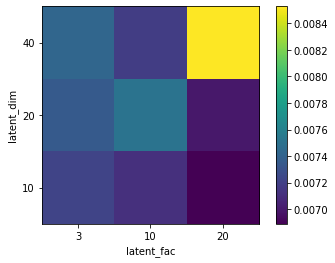

In [27]:
plt.imshow(np.average(mse_val_vae_binned,axis=0))
plt.xlim(-0.5,2.5)
plt.ylim(-0.5,2.5)
plt.xticks([0,1,2],latent_fac_list)
plt.yticks([0,1,2],latent_dim_list)
plt.ylabel('latent_dim')
plt.xlabel('latent_fac')
plt.colorbar()

In [32]:
latent_dim_list[np.where(ave_mse_val_vae_binned==np.min(ave_mse_val_vae_binned))[0][0]]

10

In [33]:
latent_fac_list[np.where(ave_mse_val_vae_binned==np.min(ave_mse_val_vae_binned))[1][0]]

20

In [ ]:
latent_dim=latent_dim_list[np.where(ave_mse_val_vae_binned==np.min(ave_mse_val_vae_binned))[0][0]]
latent_fac=latent_fac_list[np.where(ave_mse_val_vae_binned==np.min(ave_mse_val_vae_binned))[1][0]]
                            
vae_binned,_,_=create_binned_lstm_vae(input_dim=n_neuron, timesteps=n_bin, batch_size=1,
                                        intermediate_dim=latent_dim, latent_dim=latent_dim,
                                        latent_fac=latent_fac,epsilon_std=1.)
vae_binned.fit(all_bin_training_data, all_bin_training_data, epochs=150, batch_size=1, verbose=0)
            
test_reconstruction=vae_binned.predict(all_bin_testing_data,batch_size=1,verbose=0)


In [ ]:
mse = tf.keras.losses.MeanSquaredError()
mse(all_bin_testing_data, test_reconstruction).numpy()

In [22]:
np.average(mse_val_vae_binned,axis=0)[0,2]

0.006888757832348347

# evaluation

### visualize reconstruction

In [199]:
shape1,shape2=activity[frame_trial==89].shape
construct=vae.predict(activity[frame_trial==89].reshape(1,shape1,shape2),verbose=0)

In [203]:
aligned_reconstruct=align_maze([89],[construct],reshape=True)

In [204]:
np.save('aligned_reconstruct.npy',aligned_reconstruct)

### latent embedding

In [18]:
fold_var=10
vae_encoder = keras.models.load_model(save_dir+'vae_encoder_'+str(fold_var),compile=False)
vae_encoder2 = keras.models.load_model(save_dir+'vae_encoder2_'+str(fold_var),compile=False)

In [21]:
x_encoded=[]
for i in range(n_trial):
    shape1,shape2=activity_nobin[i].shape
    x_encoded.append(vae_encoder.predict(activity_nobin[i].reshape(1,shape1,shape2),verbose=0))

In [27]:
x_encoded=np.array(x_encoded)[:,0,:]

In [28]:
x_encoded.shape

(378, 20)

<IPython.core.display.Javascript object>


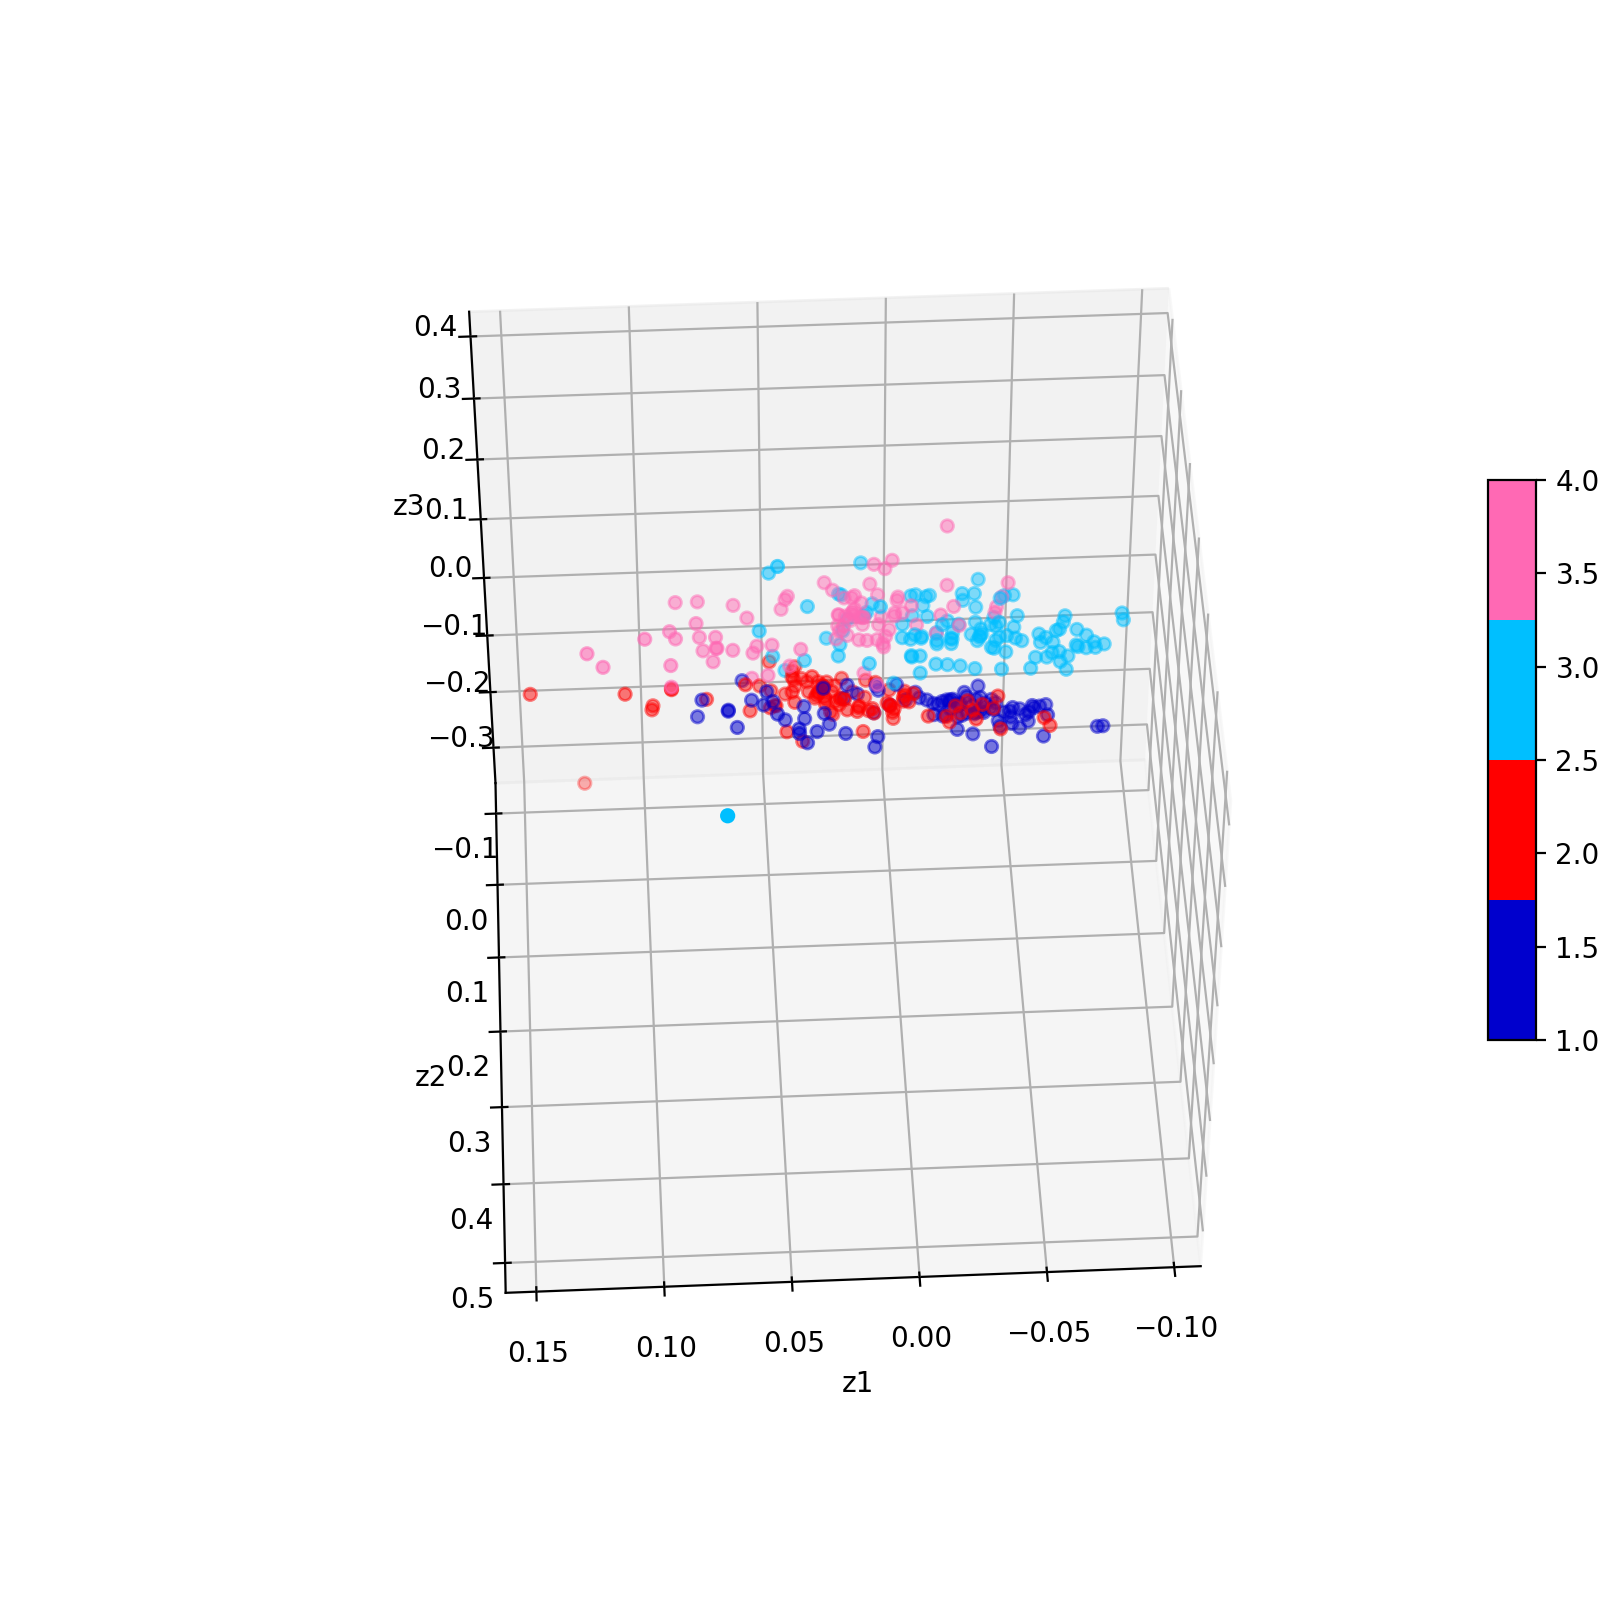

In [29]:
pca=PCA(n_components=3)
pc=pca.fit_transform(x_encoded)

%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
a=ax.scatter(pc[:,2],pc[:,1],pc[:,0],c=trialtype,cmap=cmap)
ax.set_xlabel('z1')
ax.set_ylabel('z2')
ax.set_zlabel('z3')
cbaxes = fig.add_axes([0.93, 0.35, 0.03, 0.35]) 
cbar = plt.colorbar(a, cax = cbaxes)

### latent trajectory

In [22]:
x_encoded2=[]
for i in range(n_trial):
    shape1,shape2=activity_nobin[i].shape
    x_encoded2.append(vae_encoder2.predict(activity_nobin[i].reshape(1,shape1,shape2),verbose=0))

In [39]:
aligned_encoded2=align_maze(idx_trials,x_encoded2,reshape=True)
aligned_encoded2[np.isnan(aligned_encoded2)]=0

# Specify the tensor, and the rank (np. of factors)
X, rank = aligned_data, 3

# Perform CP decompositon using TensorLy
factors_tl = non_negative_parafac(aligned_encoded2, rank=rank)

a = factors_tl[1][0]
b = factors_tl[1][1]
c = factors_tl[1][2]
v1=np.outer(a[:,0],c[:,0])
v2=np.outer(a[:,1],c[:,1])
v3=np.outer(a[:,2],c[:,2])

In [50]:
import matplotlib.colors as colors
import matplotlib.cm as cmx
inferno = cm = plt.get_cmap('jet') 
cNorm  = colors.Normalize(vmin=-0.5, vmax=0.5)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=inferno)

<IPython.core.display.Javascript object>


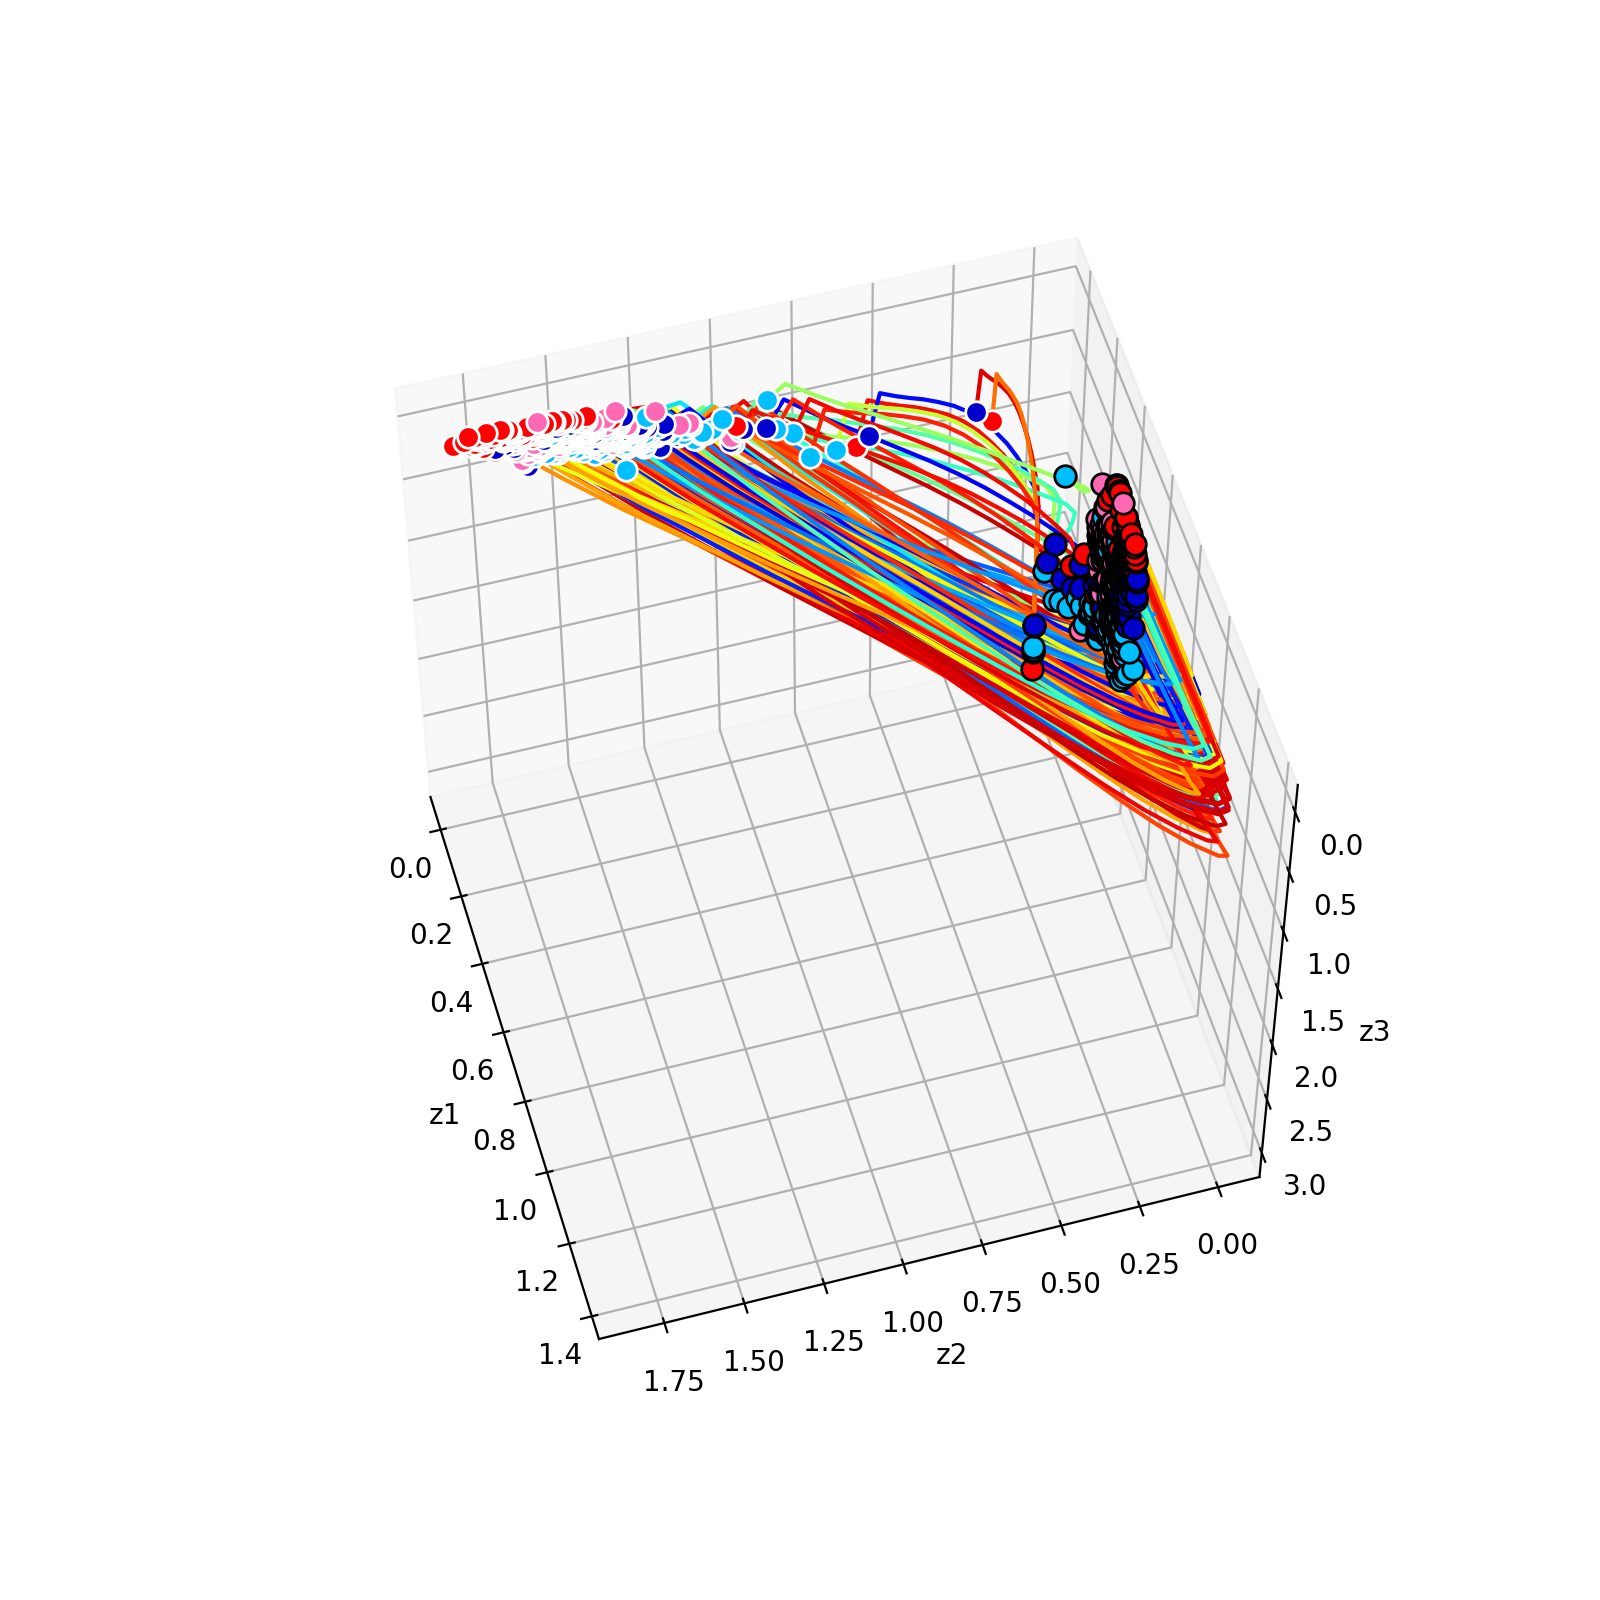

Text(0.5, 0, 'z3')

In [62]:
%matplotlib notebook

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

for i in range(n_trial):
    ax.plot3D(v1[i,:],v2[i,:],v3[i,:],
              c=scalarMap.to_rgba(rule_following[i]))
    ax.scatter(v1[i,0],v2[i,0],v3[i,0],
              c=cmaplist[int(trialtype[i]-1)],s=60,marker='o',linewidth=1,edgecolor='white')
    ax.scatter(v1[i,19],v2[i,19],v3[i,19],
              c=cmaplist[int(trialtype[i]-1)],s=60,marker='o',linewidth=1,edgecolor='black')

ax.view_init(110, 50)
ax.set_xlabel('z1')
ax.set_ylabel('z2')
ax.set_zlabel('z3')